In [1]:
import pandas as pd

# ----------------------------
# AYARLAR
# ----------------------------
INPUT_PATH = "clinvar_result_new.txt"
OUTPUT_PATH = "clinvar_minimal_labeled.csv"

KEEP_COLS = [
    "Name",
    "Gene(s)",
    "Protein change",
    "Variant type",
    "Molecular consequence",
    "Germline classification",
]

POSITIVE = {"Pathogenic", "Likely pathogenic", "Pathogenic/Likely pathogenic"}
NEGATIVE = {"Benign", "Likely benign", "Benign/Likely benign"}
ALLOWED = POSITIVE.union(NEGATIVE)

# ----------------------------
# 1) Dosyayı oku
# ----------------------------
df = pd.read_csv(INPUT_PATH, sep="\t", comment="#", low_memory=False)
print("Ham veri:", df.shape)

# ----------------------------
# 2) Sadece gerekli kolonlar
# ----------------------------
missing = [c for c in KEEP_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Eksik kolonlar: {missing}")

df = df[KEEP_COLS].copy()
print("Kolon küçültme sonrası:", df.shape)

# ----------------------------
# 3) Sadece izinli klinik sınıflar
# ----------------------------
df["Germline classification"] = (
    df["Germline classification"]
    .astype(str)
    .str.strip()
)

before = df.shape[0]
df = df[df["Germline classification"].isin(ALLOWED)].copy()
print("Atılan (VUS vs.):", before - df.shape[0])

# ----------------------------
# 4) Label ekle
# ----------------------------
df["label"] = df["Germline classification"].apply(
    lambda x: 1 if x in POSITIVE else 0
)

# ----------------------------
# 5) Kaydet
# ----------------------------
df.to_csv(OUTPUT_PATH, index=False)

# ----------------------------
# 6) Kontrol çıktıları
# ----------------------------
print("\n✅ Kaydedildi:", OUTPUT_PATH)
print("Final boyut:", df.shape)

print("\nGermline classification dağılımı:")
print(df["Germline classification"].value_counts())

print("\nLabel dağılımı:")
print(df["label"].value_counts())

print("\nÖrnek ilk 5 satır:")
print(df.head().to_string(index=False))


Ham veri: (715, 25)
Kolon küçültme sonrası: (715, 6)
Atılan (VUS vs.): 0

✅ Kaydedildi: clinvar_minimal_labeled.csv
Final boyut: (715, 7)

Germline classification dağılımı:
Germline classification
Likely benign                   290
Pathogenic                      149
Likely pathogenic               132
Pathogenic/Likely pathogenic     84
Benign                           49
Benign/Likely benign             11
Name: count, dtype: int64

Label dağılımı:
label
1    365
0    350
Name: count, dtype: int64

Örnek ilk 5 satır:
                                             Name                                                                                                                                                                                                                                                                                                                                                                                                                                         

#3.1

In [7]:

# Temizlik
df["Variant type"] = (df["Variant type"].astype(str)
                      .str.lower().str.strip()
                      .str.replace(r"\s+", " ", regex=True))

df["Molecular consequence"] = (df["Molecular consequence"].fillna("")
                               .astype(str).str.lower().str.strip()
                               .str.replace(r"\s+", " ", regex=True))

# One-hot (Variant type)
variant_type_dummies = pd.get_dummies(df["Variant type"], prefix="vt")

# Multi-hot (Molecular consequence)
consequence_dummies = df["Molecular consequence"].str.get_dummies(sep="|").add_prefix("mc_")

# Boş consequence kolonu varsa kaldır
for bad in ["mc_", "mc_ "]:
    if bad in consequence_dummies.columns:
        consequence_dummies = consequence_dummies.drop(columns=[bad])

# Protein change flag'leri
df["Protein change"] = df["Protein change"].fillna("").astype(str)
df["is_stop"] = df["Protein change"].str.contains(r"(\*|Ter)", regex=True).astype(int)
df["is_frameshift"] = df["Protein change"].str.contains("fs").astype(int)
df["is_synonymous"] = df["Protein change"].str.contains("=").astype(int)
basic_flags = df[["is_stop", "is_frameshift", "is_synonymous"]]

# Feature matrix
X = pd.concat([variant_type_dummies, consequence_dummies, basic_flags], axis=1)
y = df["label"]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Variant type sayıları:\n", df["Variant type"].value_counts())
print("Consequence sayıları (ilk 10 kolon):\n", consequence_dummies.sum().sort_values(ascending=False).head(10))


X shape: (715, 23)
y shape: (715,)
Variant type sayıları:
 Variant type
single nucleotide variant    543
deletion                      93
duplication                   38
copy number loss              11
microsatellite                11
copy number gain               7
insertion                      6
indel                          6
Name: count, dtype: int64
Consequence sayıları (ilk 10 kolon):
 mc_intron variant             296
mc_synonymous variant         145
mc_missense variant           131
mc_5 prime utr variant        109
mc_frameshift variant          92
mc_nonsense                    52
mc_splice donor variant        27
mc_splice acceptor variant     25
mc_initiator_codon_variant      7
mc_3 prime utr variant          5
dtype: int64


/tmp/ipython-input-1237399356.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["is_stop"] = df["Protein change"].str.contains(r"(\*|Ter)", regex=True).astype(int)


#3.2

In [8]:
# ============================
# Milestone 3 - Adım 2
# Baseline Model: Logistic Regression
# ============================

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
import pandas as pd
import numpy as np

# 1) Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# 2) Model
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear"
)

model.fit(X_train, y_train)

# 3) Tahminler
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 4) Metrikler
print("\nAccuracy:", accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# 5) En önemli feature'lar
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": model.coef_[0]
})

coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

print("\nEn etkili 10 feature:")
print(coef_df.head(10).to_string(index=False))


Train shape: (536, 23)
Test shape: (179, 23)

Accuracy: 0.9497206703910615

Confusion Matrix:
[[83  5]
 [ 4 87]]

Classification Report:
              precision    recall  f1-score   support

           0      0.954     0.943     0.949        88
           1      0.946     0.956     0.951        91

    accuracy                          0.950       179
   macro avg      0.950     0.950     0.950       179
weighted avg      0.950     0.950     0.950       179

ROC-AUC: 0.9793331668331668

En etkili 10 feature:
                     feature      coef  abs_coef
         mc_missense variant  3.856049  3.856049
       mc_synonymous variant -2.920738  2.920738
     mc_splice donor variant  2.671892  2.671892
                 mc_nonsense  2.347956  2.347956
           mc_intron variant -2.339995  2.339995
  mc_splice acceptor variant  2.302590  2.302590
                     is_stop  1.998720  1.998720
       mc_frameshift variant  1.622155  1.622155
               is_frameshift  1.583438  1.58

#3.3

In [9]:
# ============================
# Milestone 3 - Adım 3
# Feature set v2 (ACADM-odaklı)
# ============================

import pandas as pd
import numpy as np

# --- 1) Molecular consequence -> impact level ---
HIGH_IMPACT = {
    "frameshift variant",
    "stop gained",
    "nonsense",
    "splice donor variant",
    "splice acceptor variant"
}

MODERATE_IMPACT = {
    "missense variant"
}

LOW_IMPACT = {
    "synonymous variant",
    "intron variant",
    "5 prime utr variant",
    "3 prime utr variant"
}

def consequence_to_impact(mc):
    mc = mc.lower()
    parts = mc.split("|")
    if any(p in HIGH_IMPACT for p in parts):
        return "high"
    if any(p in MODERATE_IMPACT for p in parts):
        return "moderate"
    if any(p in LOW_IMPACT for p in parts):
        return "low"
    return "other"

df["impact_level"] = df["Molecular consequence"].fillna("").apply(consequence_to_impact)

impact_dummies = pd.get_dummies(df["impact_level"], prefix="impact")

print("Impact level dağılımı:")
print(df["impact_level"].value_counts())

# --- 2) Protein change -> pozisyon bilgisi ---
# Örnek: p.Arg123Ser -> 123

df["aa_position"] = (
    df["Protein change"]
    .str.extract(r"(\d+)")
    .astype(float)
)

# ACADM ~ 421 aa (yaklaşık)
df["is_early_position"] = (df["aa_position"] <= 150).astype(int)
df["is_late_position"] = (df["aa_position"] >= 300).astype(int)

position_flags = df[["is_early_position", "is_late_position"]]

# --- 3) Yeni feature matrix (v2) ---
X_v2 = pd.concat(
    [
        impact_dummies,
        position_flags
    ],
    axis=1
)

y_v2 = df["label"]

print("\nX_v2 shape:", X_v2.shape)
print("y_v2 shape:", y_v2.shape)


Impact level dağılımı:
impact_level
low         341
high        194
moderate    128
other        52
Name: count, dtype: int64

X_v2 shape: (715, 6)
y_v2 shape: (715,)


#3.4

In [10]:
# ============================
# Milestone 3 - Adım 4
# Model karşılaştırması
# Baseline (X) vs ACADM-özel (X_v2)
# ============================

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# --- Aynı split indexlerini kullan ---
idx_train, idx_test = train_test_split(
    X.index,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Baseline veri
Xb_train, Xb_test = X.loc[idx_train], X.loc[idx_test]
yb_train, yb_test = y.loc[idx_train], y.loc[idx_test]

# ACADM-özel veri
Xv2_train, Xv2_test = X_v2.loc[idx_train], X_v2.loc[idx_test]
yv2_train, yv2_test = y_v2.loc[idx_train], y_v2.loc[idx_test]

# --- Model tanımı ---
def train_eval(Xtr, Xte, ytr, yte):
    model = LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    )
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    y_proba = model.predict_proba(Xte)[:, 1]
    return {
        "accuracy": accuracy_score(yte, y_pred),
        "roc_auc": roc_auc_score(yte, y_proba)
    }

# --- Eğit ve değerlendir ---
baseline_metrics = train_eval(Xb_train, Xb_test, yb_train, yb_test)
v2_metrics = train_eval(Xv2_train, Xv2_test, yv2_train, yv2_test)

# --- Sonuç tablosu ---
comparison_df = pd.DataFrame(
    [baseline_metrics, v2_metrics],
    index=["Baseline (generic features)", "ACADM-specific (v2)"]
)

print("\nModel Karşılaştırması:")
print(comparison_df)



Model Karşılaştırması:
                             accuracy   roc_auc
Baseline (generic features)  0.949721  0.979333
ACADM-specific (v2)          0.949721  0.971154


#4.1

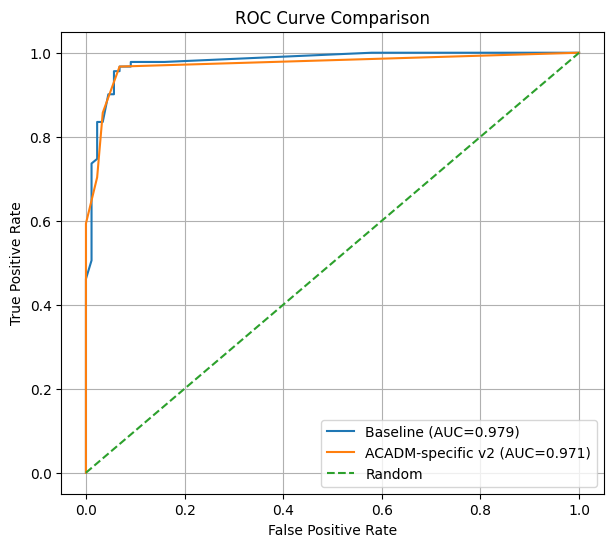

Baseline ROC-AUC: 0.9793
ACADM-specific v2 ROC-AUC: 0.9712


In [11]:
# ============================
# Milestone 4 - Adım 1
# ROC Curve: Baseline vs ACADM-specific (v2)
# ============================

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

# 1) Aynı split (adil karşılaştırma)
idx_train, idx_test = train_test_split(
    X.index,
    test_size=0.25,
    random_state=42,
    stratify=y
)

Xb_train, Xb_test = X.loc[idx_train], X.loc[idx_test]
yb_train, yb_test = y.loc[idx_train], y.loc[idx_test]

Xv2_train, Xv2_test = X_v2.loc[idx_train], X_v2.loc[idx_test]
yv2_train, yv2_test = y_v2.loc[idx_train], y_v2.loc[idx_test]

# 2) Modelleri eğit
baseline_model = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
v2_model = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")

baseline_model.fit(Xb_train, yb_train)
v2_model.fit(Xv2_train, yv2_train)

# 3) Olasılıkları al
b_proba = baseline_model.predict_proba(Xb_test)[:, 1]
v2_proba = v2_model.predict_proba(Xv2_test)[:, 1]

# 4) ROC curve + AUC
b_fpr, b_tpr, _ = roc_curve(yb_test, b_proba)
v2_fpr, v2_tpr, _ = roc_curve(yv2_test, v2_proba)

b_auc = roc_auc_score(yb_test, b_proba)
v2_auc = roc_auc_score(yv2_test, v2_proba)

# 5) Plot
plt.figure(figsize=(7, 6))
plt.plot(b_fpr, b_tpr, label=f"Baseline (AUC={b_auc:.3f})")
plt.plot(v2_fpr, v2_tpr, label=f"ACADM-specific v2 (AUC={v2_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

print("Baseline ROC-AUC:", round(b_auc, 4))
print("ACADM-specific v2 ROC-AUC:", round(v2_auc, 4))


#4.2

In [12]:
# ============================
# Milestone 4 - Adım 2
# Confusion Matrix Karşılaştırması
# ============================

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# 1) Aynı train/test split
idx_train, idx_test = train_test_split(
    X.index,
    test_size=0.25,
    random_state=42,
    stratify=y
)

Xb_train, Xb_test = X.loc[idx_train], X.loc[idx_test]
yb_train, yb_test = y.loc[idx_train], y.loc[idx_test]

Xv2_train, Xv2_test = X_v2.loc[idx_train], X_v2.loc[idx_test]
yv2_train, yv2_test = y_v2.loc[idx_train], y_v2.loc[idx_test]

# 2) Modeller
baseline_model = LogisticRegression(
    max_iter=1000, class_weight="balanced", solver="liblinear"
)
v2_model = LogisticRegression(
    max_iter=1000, class_weight="balanced", solver="liblinear"
)

baseline_model.fit(Xb_train, yb_train)
v2_model.fit(Xv2_train, yv2_train)

# 3) Tahminler
b_pred = baseline_model.predict(Xb_test)
v2_pred = v2_model.predict(Xv2_test)

# 4) Confusion matrix
cm_baseline = confusion_matrix(yb_test, b_pred)
cm_v2 = confusion_matrix(yv2_test, v2_pred)

print("Baseline Confusion Matrix:")
print(cm_baseline)

print("\nACADM-specific v2 Confusion Matrix:")
print(cm_v2)

# 5) Daha okunaklı tablo
def cm_to_df(cm):
    return pd.DataFrame(
        cm,
        index=["True Benign", "True Pathogenic"],
        columns=["Pred Benign", "Pred Pathogenic"]
    )

print("\nBaseline (tablo):")
print(cm_to_df(cm_baseline))

print("\nACADM-specific v2 (tablo):")
print(cm_to_df(cm_v2))

# 6) Classification report (detay)
print("\nBaseline Classification Report:")
print(classification_report(yb_test, b_pred))

print("\nACADM-specific v2 Classification Report:")
print(classification_report(yv2_test, v2_pred))


Baseline Confusion Matrix:
[[83  5]
 [ 4 87]]

ACADM-specific v2 Confusion Matrix:
[[82  6]
 [ 3 88]]

Baseline (tablo):
                 Pred Benign  Pred Pathogenic
True Benign               83                5
True Pathogenic            4               87

ACADM-specific v2 (tablo):
                 Pred Benign  Pred Pathogenic
True Benign               82                6
True Pathogenic            3               88

Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95        88
           1       0.95      0.96      0.95        91

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179


ACADM-specific v2 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        88
           1       0.94      0.97      0.95        91

    accur